In [11]:
import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.optimizers import Adam,SGD

with open("cranfield\cran_qrels.json", "r") as f:
    data = json.load(f)

doc_seq = np.genfromtxt('cranfield_sequences/doc_seq.csv', dtype=int)
query_seq = np.genfromtxt('cranfield_sequences/q_seq.csv', dtype=int)
y = tf.one_hot(np.array([data[i]['position'] for i in range(len(data))]),depth=4)
x_doc_seq = np.array([doc_seq[int(data[i]['id'])-1] for i in range(len(data))])
x_query_seq = np.array([query_seq[int(data[i]['query_num'])-1] for i in range(len(data))])

HIDDEN_SIZE = 128
VOCAB_SIZE = 9000
EMBEDDING_DIM = 64
NUM_CLASSES = 4
DENSE_SIZE = 64

doc_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="doc_input")
query_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="query_input")

embedding_layer = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)

doc_embedding = embedding_layer(doc_input)
doc_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(doc_embedding)

query_embedding = embedding_layer(query_input)
query_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(query_embedding)

concatenated = tf.keras.layers.concatenate([doc_encoder, query_encoder])
dense_layer_1 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(concatenated)
dense_layer_2 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_2)
output_layer = tf.keras.layers.Dense(4, activation="softmax")(dense_layer_3)
model = tf.keras.models.Model(inputs=[doc_input, query_input], outputs=output_layer)

opt = Adam(learning_rate=1e-4)
model.compile(loss = "categorical_crossentropy", optimizer = opt)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(
    {"doc_input": x_doc_seq, "query_input": x_query_seq},
    y,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)



Epoch 1/10
46/46 [==============================] - 32s 636ms/step - loss: 1.0983 - accuracy: 0.3553 - val_loss: 1.0115 - val_accuracy: 0.4538
Epoch 2/10
46/46 [==============================] - 29s 623ms/step - loss: 1.0398 - accuracy: 0.3860 - val_loss: 0.9503 - val_accuracy: 0.4538
Epoch 3/10
46/46 [==============================] - 29s 632ms/step - loss: 0.9984 - accuracy: 0.3860 - val_loss: 0.9053 - val_accuracy: 0.4538
Epoch 4/10
46/46 [==============================] - 30s 645ms/step - loss: 0.9697 - accuracy: 0.3860 - val_loss: 0.8759 - val_accuracy: 0.4538
Epoch 5/10
46/46 [==============================] - 28s 600ms/step - loss: 0.9498 - accuracy: 0.3860 - val_loss: 0.8548 - val_accuracy: 0.4538
Epoch 6/10
46/46 [==============================] - 33s 720ms/step - loss: 0.9349 - accuracy: 0.3860 - val_loss: 0.8430 - val_accuracy: 0.4538
Epoch 7/10
46/46 [==============================] - 32s 703ms/step - loss: 0.9240 - accuracy: 0.3860 - val_loss: 0.8292 - val_accuracy: 0.4538

In [18]:
import json
import numpy as np

cranfield_docs_url = "cranfield/cran_docs.json"
cranfield_queries_url = "cranfield/cran_queries.json"

def url_to_corpus(url,mode):

  with open(url, 'r') as f: data = json.load(f)

  num_docs = len(data)
  docs = np.empty(num_docs, dtype='object')

  for i in range(num_docs): docs[i] = data[i][mode]

  return docs

docs = url_to_corpus(cranfield_docs_url,'body')
queries = url_to_corpus(cranfield_queries_url,'query')

In [2]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertModel.from_pretrained(model_name)

# Prepare input data
max_seq_len = 400  # Maximum sequence length for BERT input
batch_size = 8
x_docs = docs
x_queries = queries

# Tokenize and encode input data for documents
doc_input_ids = []
doc_attention_masks = []
for doc in x_docs:
    # Tokenize and encode input text
    encoded_dict = tokenizer.encode_plus(
        doc,
        add_special_tokens=True,
        max_length=max_seq_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    doc_input_ids.append(encoded_dict['input_ids'])
    doc_attention_masks.append(encoded_dict['attention_mask'])

# Convert input data to tensors for documents
doc_input_ids = tf.concat(doc_input_ids, axis=0)
doc_attention_masks = tf.concat(doc_attention_masks, axis=0)

# Get hidden state representations for documents
doc_hidden_states = []
for i in range(0, len(x_docs), batch_size):
    print(i)
    batch_doc_input_ids = doc_input_ids[i:i+batch_size]
    batch_doc_attention_masks = doc_attention_masks[i:i+batch_size]
    batch_doc_outputs = model(input_ids=batch_doc_input_ids, attention_mask=batch_doc_attention_masks)
    batch_doc_hidden_states = batch_doc_outputs.last_hidden_state[:, 0, :]
    doc_hidden_states.append(batch_doc_hidden_states)
doc_hidden_states = tf.concat(doc_hidden_states, axis=0)

# Tokenize and encode input data for queries
query_input_ids = []
query_attention_masks = []
for query in x_queries:
    # Tokenize and encode input text
    encoded_dict = tokenizer.encode_plus(
        query,
        add_special_tokens=True,
        max_length=max_seq_len,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    query_input_ids.append(encoded_dict['input_ids'])
    query_attention_masks.append(encoded_dict['attention_mask'])

# Convert input data to tensors for queries
query_input_ids = tf.concat(query_input_ids, axis=0)
query_attention_masks = tf.concat(query_attention_masks, axis=0)

# Get hidden state representations for queries
query_hidden_states = []
for i in range(0, len(x_queries), batch_size):

    batch_query_input_ids = query_input_ids[i:i+batch_size]
    batch_query_attention_masks = query_attention_masks[i:i+batch_size]
    batch_query_outputs = model(input_ids=batch_query_input_ids, attention_mask=batch_query_attention_masks)
    batch_query_hidden_states = batch_query_outputs.last_hidden_state[:, 0, :]
    query_hidden_states.append(batch_query_hidden_states)
    
query_hidden_states = tf.concat(query_hidden_states, axis=0)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. 

0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224
232
240
248
256
264
272
280
288
296
304
312
320
328
336
344
352
360
368
376
384
392
400
408
416
424
432
440
448
456
464
472
480
488
496
504
512
520
528
536
544
552
560
568
576
584
592
600
608
616
624
632
640
648
656
664
672
680
688
696
704
712
720
728
736
744
752
760
768
776
784
792
800
808
816
824
832
840
848
856
864
872
880
888
896
904
912
920
928
936
944
952
960
968
976
984
992
1000
1008
1016
1024
1032
1040
1048
1056
1064
1072
1080
1088
1096
1104
1112
1120
1128
1136
1144
1152
1160
1168
1176
1184
1192
1200
1208
1216
1224
1232
1240
1248
1256
1264
1272
1280
1288
1296
1304
1312
1320
1328
1336
1344
1352
1360
1368
1376
1384
1392
0
8
16
24
32
40
48
56
64
72
80
88
96
104
112
120
128
136
144
152
160
168
176
184
192
200
208
216
224


In [4]:
np.savetxt('cranfield_sequences/doc_seq_embedding.csv', doc_hidden_states, fmt='%s')
np.savetxt('cranfield_sequences/q_seq_embedding.csv', query_hidden_states, fmt='%s')

c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in T

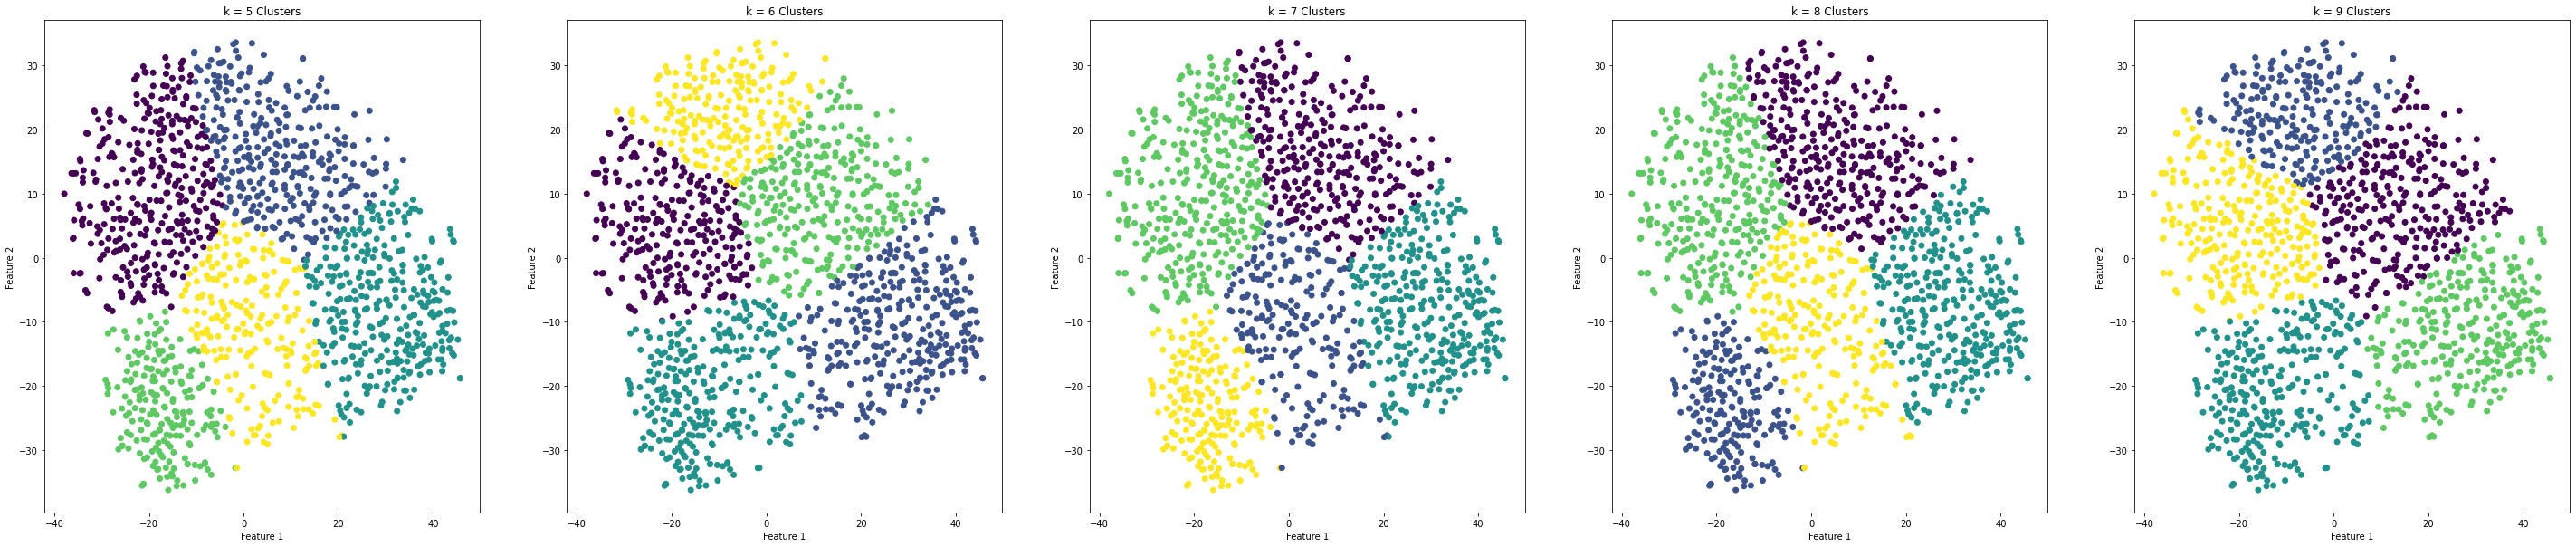

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

k = 5
method = "TSNE"

plt.figure(figsize=(50,10))

for i in range(5):

    if(method=="PCA"):

        pca = PCA(n_components=2)
        doc_seq_embeddings_np_2d = pca.fit_transform(doc_seq_embeddings)

    else:

        tsne = TSNE(n_components=2, random_state=42)
        doc_seq_embeddings_np_2d = tsne.fit_transform(doc_seq_embeddings)

    gmm = GaussianMixture(n_components=k)
    gmm.fit(doc_seq_embeddings_np_2d)
    labels = gmm.predict(doc_seq_embeddings_np_2d)

    plt.subplot(1,5,i+1)

    plt.scatter(doc_seq_embeddings_np_2d[:, 0], doc_seq_embeddings_np_2d[:, 1], c=labels, cmap='viridis')
    plt.title('Clustered Data')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title("k = {} Clusters".format(k+i))

In [28]:
with open("cranfield\cran_qrels.json", "r") as f:
    data = json.load(f)

y = tf.one_hot(np.array([data[i]['position'] for i in range(len(data))]),depth=4)
x_doc_seq = np.array([doc_seq_embeddings[int(data[i]['id'])-1] for i in range(len(data))])
x_query_seq = np.array([query_seq_embeddings[int(data[i]['query_num'])-1] for i in range(len(data))])

doc_shape = doc_seq_embeddings.shape[1:]
query_shape = query_seq_embeddings.shape[1:]

doc_inputs = tf.keras.layers.Input(shape=doc_shape)
query_inputs = tf.keras.layers.Input(shape=query_shape)

doc = tf.keras.layers.Dense(128, activation='relu')(doc_inputs)
query = tf.keras.layers.Dense(128, activation='relu')(query_inputs)

x = tf.keras.layers.Concatenate()([doc, query])
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

opt = tf.keras.optimizers.SGD(learning_rate = 1e-5 , momentum = 0.9)

model = tf.keras.Model(inputs=[doc_inputs, query_inputs], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit([x_doc_seq, x_query_seq], y, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
46/46 [==============================] - 1s 10ms/step - loss: 1.0751 - accuracy: 0.2219 - val_loss: 1.0362 - val_accuracy: 0.1658
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: 1.0562 - accuracy: 0.2219 - val_loss: 1.0132 - val_accuracy: 0.1685
Epoch 3/100
46/46 [==============================] - 0s 4ms/step - loss: 1.0389 - accuracy: 0.2321 - val_loss: 0.9930 - val_accuracy: 0.1712
Epoch 4/100
46/46 [==============================] - 0s 4ms/step - loss: 1.0240 - accuracy: 0.2417 - val_loss: 0.9749 - val_accuracy: 0.1793
Epoch 5/100
46/46 [==============================] - 0s 4ms/step - loss: 1.0108 - accuracy: 0.2505 - val_loss: 0.9598 - val_accuracy: 0.2038
Epoch 6/100
46/46 [==============================] - 0s 4ms/step - loss: 0.9994 - accuracy: 0.2675 - val_loss: 0.9458 - val_accuracy: 0.2174
Epoch 7/100
46/46 [==============================] - 0s 4ms/step - loss: 0.9893 - accuracy: 0.2920 - val_loss: 0.9333 - val_accuracy: 0.2582
Epoch 8/100


In [ ]:
HIDDEN_SIZE = 128
VOCAB_SIZE = 9000
EMBEDDING_DIM = 300
NUM_CLASSES = 4
DENSE_SIZE = 64

doc_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="doc_input")
query_input = tf.keras.layers.Input(shape=(None,), dtype="int32", name="query_input")

embedding_layer = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM)

doc_embedding = embedding_layer(doc_input)
doc_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(doc_embedding)

query_embedding = embedding_layer(query_input)
query_encoder = tf.keras.layers.LSTM(HIDDEN_SIZE)(query_embedding)

concatenated = tf.keras.layers.concatenate([doc_encoder, query_encoder])
dense_layer_1 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(concatenated)
dense_layer_2 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_1)
dense_layer_3 = tf.keras.layers.Dense(DENSE_SIZE, activation="relu")(dense_layer_2)
output_layer = tf.keras.layers.Dense(4, activation="softmax")(dense_layer_3)
model = tf.keras.models.Model(inputs=[doc_input, query_input], outputs=output_layer)


pretrained_embeddings = np.genfromtxt('pretrained_embeddings.csv', dtype=float)
model.layers[2].set_weights([pretrained_embeddings])
model.layers[2].trainable = True

# optimizer = Adam(learning_rate=1e-4)
opt = SGD(learning_rate = 1e-3, momentum=0.9)
model.compile(loss = "categorical_crossentropy", optimizer = opt)

model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(
    {"doc_input": x_doc_seq, "query_input": x_query_seq},
    y,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

In [1]:
from utilities import cluster_2d, clustering, train, pickel_dictionary
from sklearn.preprocessing import StandardScaler
import numpy as np

ss = StandardScaler()
doc_seq_embeddings = np.genfromtxt('cranfield_sequences\doc_seq_embedding.csv', dtype=float)
doc_seq_embeddings = ss.fit_transform(doc_seq_embeddings)

ss = StandardScaler()
doc_seq_embeddings_2 = np.genfromtxt('cranfield_sequences\doc_seq_embedding_2.csv', dtype=float)
doc_seq_embeddings_2 = ss.fit_transform(doc_seq_embeddings_2)

ss = StandardScaler()
query_seq_embeddings = np.genfromtxt('cranfield_sequences\q_seq_embedding.csv', dtype=float)
query_seq_embeddings = ss.fit_transform(query_seq_embeddings)

ss = StandardScaler()
query_seq_embeddings_2 = np.genfromtxt('cranfield_sequences\q_seq_embedding_2.csv', dtype=float)
query_seq_embeddings_2 = ss.fit_transform(query_seq_embeddings_2)

100%|██████████| 21/21 [04:49<00:00, 13.80s/it]


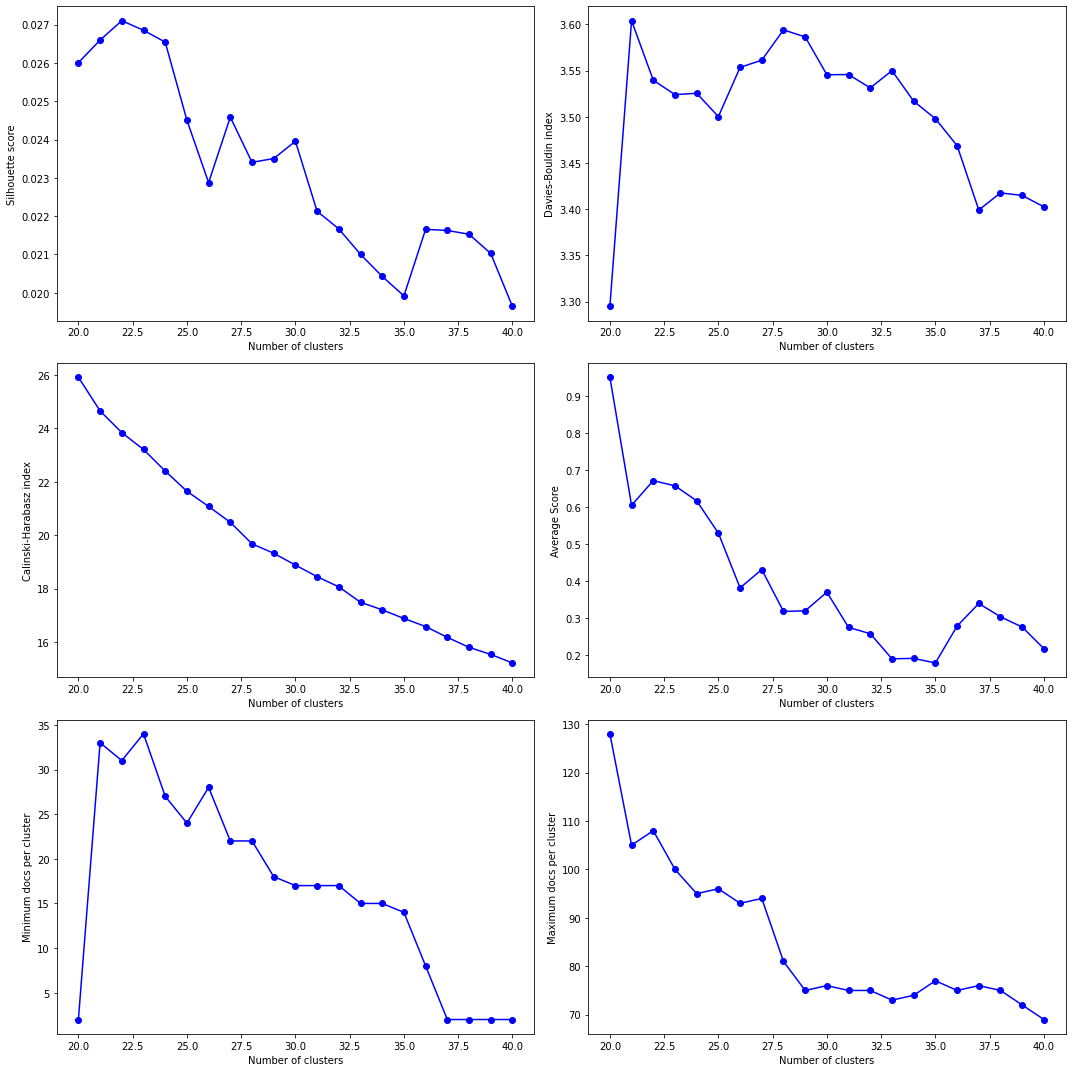

In [11]:
clustering(doc_seq_embeddings, 42, range(20,41))

100%|██████████| 21/21 [01:46<00:00,  5.09s/it]


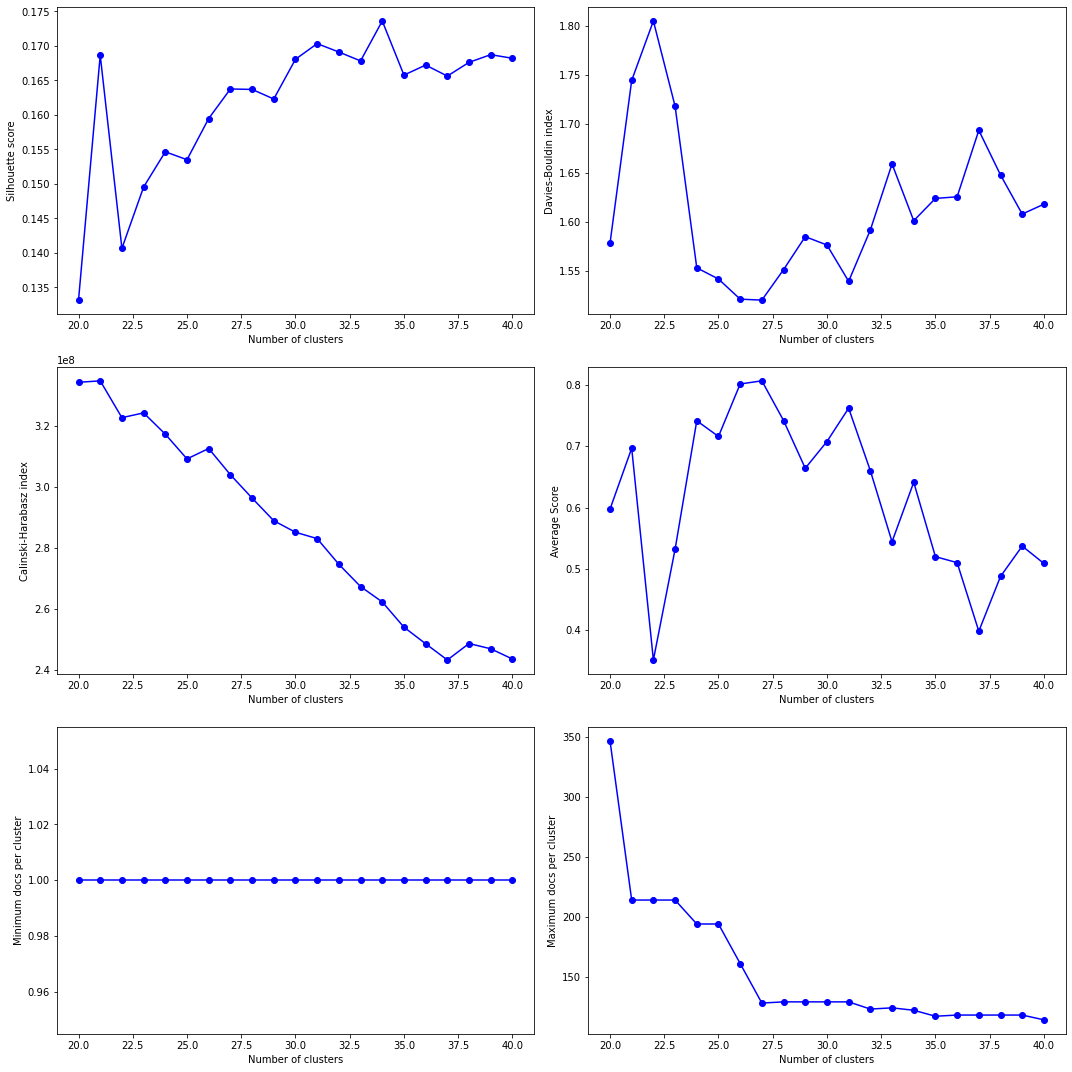

In [16]:
clustering(doc_seq_embeddings_2, 42, range(20,41))

Epoch 1/20
368/368 [==============================] - 2s 3ms/step - loss: 1.3769 - accuracy: 0.2001 - val_loss: 1.3316 - val_accuracy: 0.1603
Epoch 2/20
368/368 [==============================] - 1s 3ms/step - loss: 1.3066 - accuracy: 0.1995 - val_loss: 1.2678 - val_accuracy: 0.1603
Epoch 3/20
368/368 [==============================] - 1s 3ms/step - loss: 1.2476 - accuracy: 0.2035 - val_loss: 1.2134 - val_accuracy: 0.1603
Epoch 4/20
368/368 [==============================] - 1s 3ms/step - loss: 1.1972 - accuracy: 0.2076 - val_loss: 1.1664 - val_accuracy: 0.1658
Epoch 5/20
368/368 [==============================] - 1s 3ms/step - loss: 1.1540 - accuracy: 0.2076 - val_loss: 1.1262 - val_accuracy: 0.1766
Epoch 6/20
368/368 [==============================] - 1s 3ms/step - loss: 1.1166 - accuracy: 0.2165 - val_loss: 1.0906 - val_accuracy: 0.1929
Epoch 7/20
368/368 [==============================] - 1s 3ms/step - loss: 1.0847 - accuracy: 0.2240 - val_loss: 1.0604 - val_accuracy: 0.2283
Epoch 

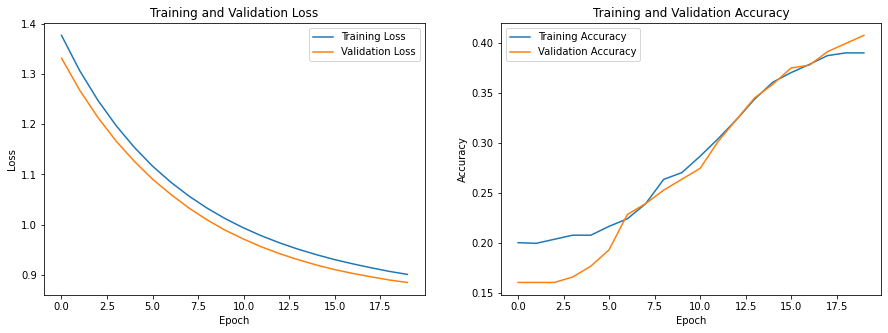

In [9]:
train(doc_seq_embeddings, query_seq_embeddings)

Epoch 1/20
368/368 [==============================] - 2s 2ms/step - loss: 1.1264 - accuracy: 0.2335 - val_loss: 1.0710 - val_accuracy: 0.2636
Epoch 2/20
368/368 [==============================] - 1s 2ms/step - loss: 1.1090 - accuracy: 0.2437 - val_loss: 1.0503 - val_accuracy: 0.2799
Epoch 3/20
368/368 [==============================] - 1s 2ms/step - loss: 1.0928 - accuracy: 0.2662 - val_loss: 1.0319 - val_accuracy: 0.3261
Epoch 4/20
368/368 [==============================] - 1s 2ms/step - loss: 1.0782 - accuracy: 0.2988 - val_loss: 1.0150 - val_accuracy: 0.3505
Epoch 5/20
368/368 [==============================] - 1s 2ms/step - loss: 1.0651 - accuracy: 0.3274 - val_loss: 1.0002 - val_accuracy: 0.3967
Epoch 6/20
368/368 [==============================] - 1s 2ms/step - loss: 1.0530 - accuracy: 0.3322 - val_loss: 0.9862 - val_accuracy: 0.4130
Epoch 7/20
368/368 [==============================] - 1s 2ms/step - loss: 1.0419 - accuracy: 0.3431 - val_loss: 0.9731 - val_accuracy: 0.4158
Epoch 

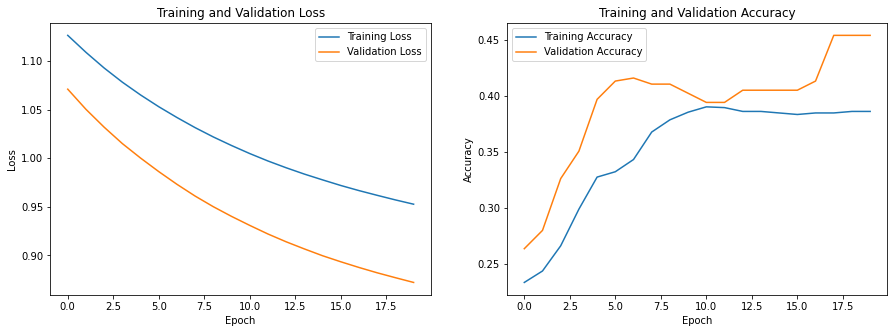

In [10]:
train(doc_seq_embeddings_2, query_seq_embeddings_2)

In [4]:
pickel_dictionary(doc_seq_embeddings_2, 'pickel_dictionaries\centroid_mapping_seq_2.pkl', 26, 42)
pickel_dictionary(doc_seq_embeddings, 'pickel_dictionaries\centroid_mapping_seq.pkl', 21, 42)

c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


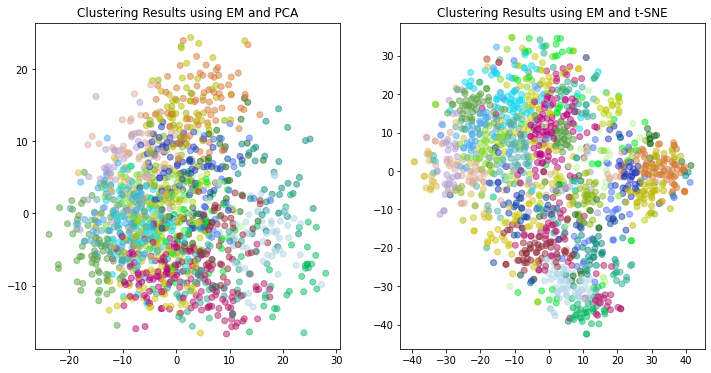

In [18]:
cluster_2d(doc_seq_embeddings, 26, 42)

c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\palas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


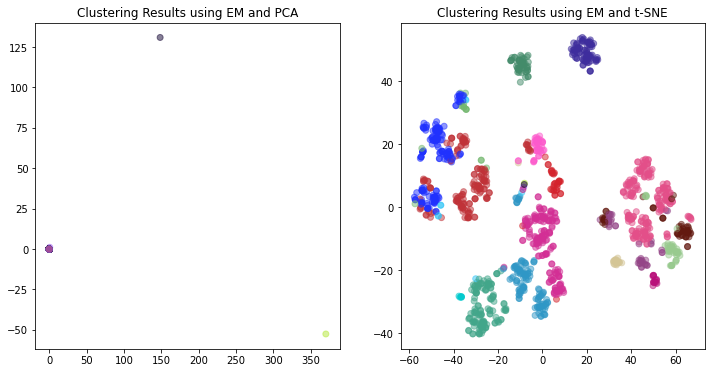

In [19]:
cluster_2d(doc_seq_embeddings_2, 21, 42)

In [1]:
import tensorflow as tf
import numpy as np
import json

with open("cranfield\cran_qrels.json", "r") as f:
    data = json.load(f)

doc_seq = np.genfromtxt('cranfield_sequences/doc_seq.csv', dtype=int)
query_seq = np.genfromtxt('cranfield_sequences/q_seq.csv', dtype=int)
y = tf.one_hot(np.array([data[i]['position'] for i in range(len(data))]),depth=4)
x_doc_seq = np.array([doc_seq[int(data[i]['id'])-1] for i in range(len(data))])
x_query_seq = np.array([query_seq[int(data[i]['query_num'])-1] for i in range(len(data))])

In [61]:
import torch
import torch.nn as nn

class lstm(nn.Module):
    def __init__(self, hidden_size, output_size, vocab_size, embedding_dim):
        super(lstm, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq):

        embedded = self.embedding(input_seq)
        
        h0 = torch.zeros(1, input_seq.size(1), self.hidden_size)
        c0 = torch.zeros(1, input_seq.size(1), self.hidden_size)

        h0 = h0.to('cuda')
        c0 = c0.to('cuda')
        
        lstm_out, _ = self.lstm(embedded, (h0, c0))
        last_hidden = lstm_out[-1, :, :]
        output = self.linear(last_hidden)

        return lstm_out, output



In [66]:
y_doc_seq = np.concatenate((x_doc_seq[:, 1:], np.zeros((x_doc_seq.shape[0], 1))), axis=1)
y_query_seq = np.concatenate((x_query_seq[:, 1:], np.zeros((x_query_seq.shape[0], 1))), axis=1)
X_ = np.concatenate([x_doc_seq, x_query_seq])
y_ = np.concatenate([y_doc_seq, y_query_seq])

BATCH_SIZE = 1
HIDDEN_SIZE = 128
OUTPUT_SIZE = 9000
VOCAB_SIZE = 9000
EMBEDDING_SIZE = 128

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

class custom_dataset(Dataset):

    def __init__(self, x, y):
        
        self.x = x
        self.y = y

    def __getitem__(self, index):
         
        return self.x[index],self.y[index]

    def __len__(self):

        return len(self.x)
    
train_dataset = custom_dataset(X_, y_)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [67]:
import torch.optim as optim
from time import time

LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-5
criterion = nn.CrossEntropyLoss()

res = []

for X,y in train_loader:

    torch.cuda.empty_cache()

    X = X.to('cuda')
    y = y.to('cuda')

    model = lstm(HIDDEN_SIZE, OUTPUT_SIZE, VOCAB_SIZE, EMBEDDING_SIZE)
    model.to('cuda')
    model.train()
    optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    epochs = 20

    y = F.one_hot( y.to(int) , VOCAB_SIZE)
    y = y.to(float)

    for e in range(epochs):

        optimizer.zero_grad()
        hidden,output = model(X)
        output = output.unsqueeze(0)
        
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    res.append(hidden)

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 6.00 GiB total capacity; 4.63 GiB already allocated; 0 bytes free; 5.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [70]:
res = np.array([np.array(r.cpu().data) for r in res])

In [73]:
from utilities import cluster_2d, clustering, train, pickel_dictionary

cluster_2d(res, 10, 42)

c:\Users\palas\Desktop\projects\nlp_course_project\utilities.py:444: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  distances = [cos_sim(query_embedding,centroid) for centroid in centroid_mapping if centroid is not "s"]
c:\Users\palas\Desktop\projects\nlp_course_project\utilities.py:444: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  distances = [cos_sim(query_embedding,centroid) for centroid in centroid_mapping if centroid is not "s"]


ValueError: Found array with dim 4. StandardScaler expected <= 2.

In [74]:
res.shape

(456, 1, 380, 128)